<a href="https://colab.research.google.com/github/wu162/Tipdm-2019B/blob/master/DCM_explore1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install dicom

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 117.5 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# 指定当前的工作文件夹
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Colab Notebooks/") 

In [0]:
!ls

apDCM	 DCM_explore1.ipynb  mask		    unet_membrane.hdf5
ct_scan  drive		     model-dsbowl2018-1.h5


In [0]:
//start from here
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))


def bce_dice_loss(y_true, y_pred):
    return  -dice_coef(y_true, y_pred)

def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(Adam(lr = 1e-4),binary_crossentropy, metrics = ['accuracy',dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

      
    return model

In [0]:
Scanfolder='./ct_scan/'
yfolder='./mask/'

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import dicom
%matplotlib inline

def get_data(Scanfolder, yfolder):
    subfolders=os.listdir(Scanfolder)
    subfolders.sort()
    files=[]
    for subfolder in subfolders:
        files_names=os.listdir(Scanfolder+subfolder)
        files_names.sort()
        files_dir=[Scanfolder+subfolder+'/'+names for names in files_names]
        files=files+files_dir
    X_train=np.array([plt.imread(file) for file in files])
    
    subfolders=os.listdir(yfolder)
    subfolders.sort()
    files=[]
    for subfolder in subfolders:
        files_names=os.listdir(yfolder+subfolder)
        files_names.sort()
        files_dir=[yfolder+subfolder+'/'+names for names in files_names]
        files=files+files_dir

    Y_train=np.array([plt.imread(file) for file in files])
    return X_train,Y_train

In [0]:
X_train,Y_train=get_data(Scanfolder,yfolder)

In [0]:
def cut_img(X_train,Y_train):
    return X_train[:,300:428,200:328],Y_train[:,300:428,200:328] 

In [0]:
X_train,Y_train=cut_img(X_train,Y_train)

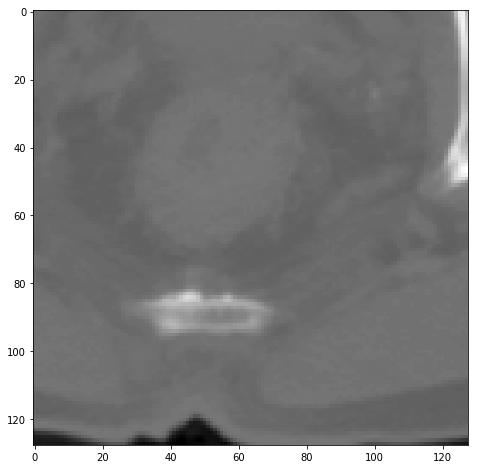

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(X_train[16],cmap=plt.cm.gray)

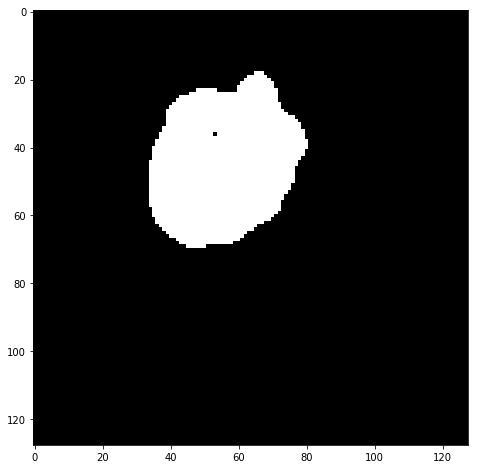

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(Y_train[16],cmap=plt.cm.gray)

In [0]:
Y_train=Y_train==1

In [0]:
np.unique(Y_train)

array([False,  True])

In [0]:
def resize_data(X_train,Y_train):
    X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
    Y_train=Y_train.reshape(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1)
    return X_train,Y_train

In [0]:
X_train,Y_train=resize_data(X_train,Y_train)

In [0]:
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model=unet(input_size = (128,128,1))
model.fit(X_train,Y_train,validation_split=0.2, batch_size=8,epochs=300,callbacks=[model_checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 100 samples, validate on 26 samples
Epoch 1/300
100/100 [==============================] - 12s 119ms/step - loss: 0.4149 - acc: 0.9707 - dice_coef: 0.0209 - val_loss: 0.1711 - val_acc: 0.9835 - val_dice_coef: 0.0182

Epoch 00001: loss improved from inf to 0.41487, saving model to unet_membrane.hdf5
Epoch 2/300
100/100 [==============================] - 2s 25ms/step - loss: 0.1294 - acc: 0.9739 - dice_coef: 0.0319 - val_loss: 0.1688 - val_acc: 0.9835 - val_dice_coef: 0.0299

Epoch 00002: loss improved from 0.41487 to 0.12944, saving model to unet_membrane.hdf5
Epoch 3/300
100/100 [==============================] - 2s 25ms/step - loss: 0.1127 - acc: 0.9739 - dice_coef: 0.0536 - val_loss: 0.1041 - val_acc: 0.9835 - val_dice_coef: 0.0226

Epoch 00003: loss improved from 0.12944 to 0.11269, saving model to unet_membrane.hdf5
Epoch 4/300
100/100 [==============================] - 2s 25ms/step - loss: 0.0971 - acc: 0.9739 - dice_coef: 0.0793 - val_loss: 0.1192 - val_acc: 0.9835 - val

In [0]:
model = unet(input_size = (128,128,1))
model.load_weights("unet_membrane.hdf5")
preds_train = model.predict(X_train,verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


126/126 [==============================] - 3s 20ms/step


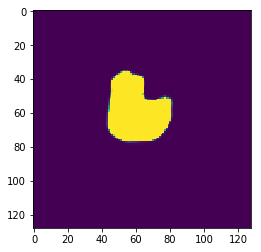

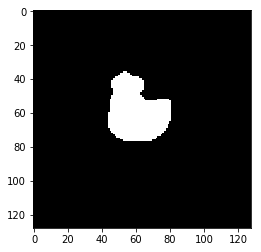

In [0]:
ix=12
plt.imshow(np.squeeze(preds_train[ix]))
plt.show()
plt.imshow(np.squeeze(Y_train[ix]),cmap=plt.cm.gray)
plt.show()